In [20]:
import numpy as np
import pandas as pd
import talib as ta
import matplotlib.pyplot as plt
pd.plotting.register_matplotlib_converters()



In [21]:
#1. 读取行情数据
z = pd.read_csv('510050.SH_15.csv',index_col=0)
#z.head()

In [22]:
from bolling_band_factor import bolling_band_factor_generator
from volatility_factor import calc_vol_mean_reversion_factor
from momentum_vol_factor import adaptive_momentum_factor
bolling_band_factor = bolling_band_factor_generator(z)
volatility_factor = calc_vol_mean_reversion_factor(z['close'])
adaptive_momentum_factor = adaptive_momentum_factor(z)


In [23]:
# v    
#volatility_factor

In [24]:
#factor = volatility_factor
factors = [
    bolling_band_factor,
    volatility_factor,
    adaptive_momentum_factor
]
factor = factors[2]
#factor.hist().set_title(f"{factor.name}")



In [25]:
# 3. 标准化因子
def normalize_factor(factor:pd.Series,window:int=2000) -> pd.Series:
    return (factor - factor.rolling(window=window).mean()) / factor.rolling(window=window).std()

normalized_factor = normalize_factor(factor)
#normalized_factor.hist(label="normalize_factor")

Text(0.5, 1.0, 'adaptive_momentum normalized_factor')

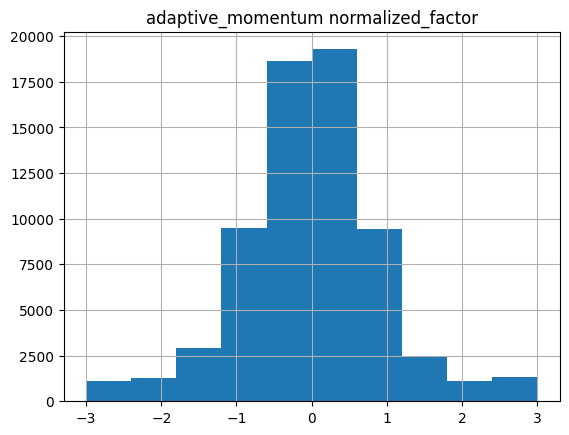

In [26]:
# 5 .因子clip u+-3sigma
normalized_factor = normalized_factor.clip(-3,3)
normalized_factor.hist().set_title(f"{factor.name} normalized_factor")

In [27]:
# 4 .计算annual夏普比率
# 输入为每日净值序列
def cal_sharp(net_values: np.array) -> float:
    '''计算夏普比率，risk free rate为无风险年化收益率，trading_days是1年的交易日'''
    risk_free_rate = 0.05  # 无风险收益率
    trading_days = 252  # 一年的交易日

    # 计算收益率
    returns = np.diff(net_values) / net_values[:-1]  # 计算相对收益率
    mean_return = np.mean(returns)  # 平均收益率

    # 计算超额收益率
    excess_return = mean_return - risk_free_rate  # 超额收益率

    # 计算收益率的标准差
    std_dev = np.std(returns,ddof = 1)  # 收益率的标准差

    # 计算夏普比率
    sharpe_ratio = (excess_return * trading_days) / std_dev  # 年化夏普比率

    return sharpe_ratio

In [28]:
#all day trading
def cal_annual_sharpe_15mins(net_values: np.array, risk_free_rate: float = 0.05) -> float:
    # 计算15分钟收益率
    returns = np.diff(net_values) / net_values[:-1]

    # 计算日收益率
    daily_return = (1 + returns) ** 96 - 1

    # 计算年化收益率
    annual_return = (1 + np.mean(daily_return)) ** 252 - 1

    # 计算年化标准差
    annual_std_dev = np.std(returns) * np.sqrt(252 * 96)

    # 计算超额收益
    excess_return = annual_return - risk_free_rate

    # 计算年化夏普比率
    if annual_std_dev == 0:
        return np.nan  # 避免除以零
    sharpe_ratio = excess_return / annual_std_dev

    return sharpe_ratio



def cal_sharp_random(net_values: np.array, period_minutes: int = 15, trading_hours: int = 4) -> float:
    '''计算年化夏普比率
    Args:
        net_values: np.array, 净值序列
        period_minutes: int, 数据周期（分钟）
        trading_hours: int, 每天交易小时数
    Returns:
        float: 年化夏普比率
    '''
    risk_free_rate = 0.03  # 年化无风险收益率
    
    # 计算年化系数
    periods_per_day = (trading_hours * 60) // period_minutes  # 每天的周期数
    trading_days = 252  # 一年的交易日数
    annual_factor = periods_per_day * trading_days  # 年化系数
    
    # 计算收益率
    returns = np.diff(net_values) / net_values[:-1]
    
    # 确保returns不为空
    if len(returns) == 0:
        return np.nan
    
    # 计算年化收益率和年化标准差
    mean_return = np.mean(returns) * annual_factor
    std_dev = np.std(returns, ddof=1) * np.sqrt(annual_factor)
    
    # 确保标准差不为零
    if std_dev == 0:
        return np.nan
        
    # 计算超额收益率
    excess_return = mean_return - risk_free_rate
    
    # 计算夏普比率
    sharpe_ratio = excess_return / std_dev
    
    return sharpe_ratio

In [29]:
normalized_factor.describe()

count    67053.000000
mean        -0.002918
std          0.944340
min         -3.000000
25%         -0.526350
50%          0.002803
75%          0.511554
max          3.000000
Name: adaptive_momentum, dtype: float64

In [30]:
# 6. 计算行情收益率
ret = z['close'].shift(-1) / z['close'] - 1
ret.describe()

count    69151.000000
mean         0.000028
std          0.003812
min         -0.063417
25%         -0.001566
50%          0.000000
75%          0.001546
max          0.100292
Name: close, dtype: float64

In [31]:
#ret.hist(bins=60)


In [32]:
# 7. net value calculation 
# 1+position ratio * return + abs(position ratio change) * rebate

def cal_net_values(pos: np.array, ret: np.array) -> np.array:
    '''计算净值序列
    pos: 仓位ratio[-300%,300%]
    ret: 未来1个周期的收益率
    '''
    fee = 0.0002  # 仓位每次变动的滑损(maker 0.02%， taker 0.05%)
    # 使用 np.hstack 组合当前仓位和仓位变化
    position_changes = np.hstack((pos[0] - 0, np.abs(np.diff(pos))))
    # 计算净值
    net_values = 1 + (pos * ret - position_changes * fee).cumsum()
    return net_values  # 返回净值序列


In [33]:
#factor.hist().set_title(f"{factor.name}")

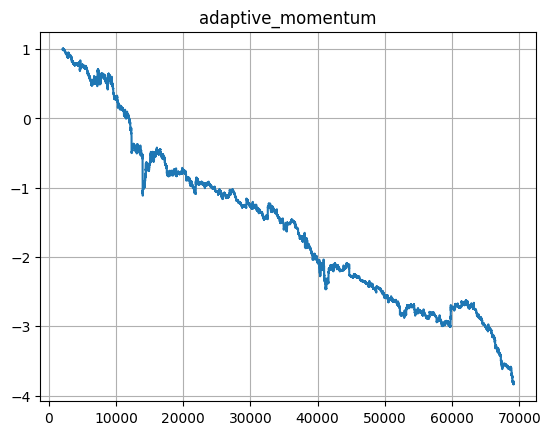

In [34]:
# define position ratio == normalized_factor
pos = normalized_factor
net_values = cal_net_values(pos,ret)

plt.plot(net_values.values)
plt.title(factor.name)
plt.grid(True)
plt.show()


In [35]:
# 8. 计算annual夏普比率
cleaned_net_values = net_values[~np.isnan(net_values)]
sharp = cal_sharp_random(cleaned_net_values,period_minutes=15,trading_hours=4)

sharp



-0.2825072987449953